<center><img src="https://i.imgur.com/zRrFdsf.png" width="700"></center>

# Analytics on GeodataFrames

Up to now, we have work with the spatial information only. This is time to use  local indicators (social, economic, physical, etc.)  at each spatial location to produce some analytics. That is possible through a series of steps:

1. Preprocessing:
    - the dataframe.
    - geodataframe.
2. Merging info fro DataFrames into the maps (a GeoDataFrame).
3. Exploring the Data.

Let's create a repo in with GitHub. Put this [file](https://drive.google.com/file/d/1EYacndGCRiF1ZHEnGa-avTXSEtqB2e7p/view?usp=sharing) in the maps folder, and this other [file](https://docs.google.com/spreadsheets/d/1xpsz9n-SBTwgtXsugmabpBJ-tCaEwg9_/edit?usp=sharing&ouid=106935788518947165917&rtpof=true&sd=true) in the data folder. 

Let's read the data in:

In [79]:
# data table
import pandas as pd
import os

datadis=pd.read_excel(os.path.join('data','dataPeru_indicadores.xlsx'),
                     dtype={'Ubigeo': object})
datadis.head()

Ubigeo Departamento Provincia  Distrito  Poblacion  Superficie   IDH2019  \
0  010202     Amazonas     Bagua  ARAMANGO      10940      809.07  0.361182   
1  010201     Amazonas     Bagua     BAGUA      26091      150.99  0.584063   
2  010203     Amazonas     Bagua  COPALLIN       6319       99.05  0.467245   
3  010204     Amazonas     Bagua  EL PARCO       1492       18.48  0.489049   
4  010205     Amazonas     Bagua     IMAZA      24323     4430.84  0.298089   

   Educ_sec_comp2019_pct  NBI2017_pct  Viv_sin_serv_hig2017_pct  
0              37.545885         62.9                       9.1  
1              70.795501         25.4                       0.7  
2              52.571361         45.4                       2.1  
3              70.215409         59.9                       1.5  
4              31.295719         88.4                      11.7

In [80]:
# map

import os
os.environ['USE_PYGEOS'] = '0'

import geopandas as gpd

datadismap=gpd.read_file(os.path.join('maps','DistritosMap.zip'))

In [81]:
datadismap.head()

DEPARTAMEN PROVINCIA                              DISTRITO INSTITUCIO  \
0      TACNA     TACNA  CORONEL GREGORIO ALBARRACIN LANCHIPA        IGN   
1      TACNA     TACNA                              POCOLLAY        IGN   
2      TACNA     TACNA                                CALANA        IGN   
3      TACNA     TACNA                                 TACNA        IGN   
4      TACNA     TACNA                                  SAMA        IGN   

                                            geometry  
0  POLYGON ((-70.17413 -18.12896, -70.17461 -18.1...  
1  POLYGON ((-69.93475 -17.92557, -69.90467 -17.9...  
2  POLYGON ((-70.11604 -17.91106, -70.11457 -17.9...  
3  POLYGON ((-70.31490 -17.94498, -70.30682 -17.9...  
4  POLYGON ((-70.42497 -17.88934, -70.48022 -17.9...

## Preprocessing

After observing both tables, it would be better if the columns with names have the same capitalization, and no extra blank spaces:

In [82]:
capitalizeColumns=lambda x: x.str.upper().str.strip()
datadis[['Provincia','Distrito']]=datadis[['Provincia','Distrito']].apply(capitalizeColumns)
datadismap[['PROVINCIA','DISTRITO']]=datadismap[['PROVINCIA','DISTRITO']].apply(capitalizeColumns)

The names from non-english speaking countries may come with some symbols that may cause trouble (', ~). Let's get rid of those:

In [83]:
import unidecode


byePunctuation=lambda x: unidecode.unidecode(x)
datadis[['Provincia','Distrito']]=datadis[['Provincia','Distrito']].applymap(byePunctuation)
datadismap[['PROVINCIA','DISTRITO']]=datadismap[['PROVINCIA','DISTRITO']].applymap(byePunctuation)

Let me see how many district we have:

In [84]:
len(datadis.Distrito),len(datadismap.DISTRITO)

(1874, 1874)

Are the name of the districts unique?

In [85]:
datadis.Distrito.duplicated().sum(),datadismap.DISTRITO.duplicated().sum()

(154, 152)

The presence of duplicates, forces we create  a column of unique values:

In [86]:
# concatenating
datadis['provDist']=["+".join(pd) for pd in zip (datadis.Provincia,datadis.Distrito)]
datadismap['provDist']=["+".join(pd) for pd in zip (datadismap.PROVINCIA,datadismap.DISTRITO)]

In [87]:
datadis['provDist'].head()

0    BAGUA+ARAMANGO
1       BAGUA+BAGUA
2    BAGUA+COPALLIN
3    BAGUA+EL PARCO
4       BAGUA+IMAZA
Name: provDist, dtype: object

In [88]:
# replacing dashes and multiple spaces by a simple space
datadis.provDist=datadis.provDist.str.replace("\-|\_|\s+"," ",regex=True)
datadismap.provDist=datadismap.provDist.str.replace("\-|\_|\s+"," ",regex=True)

In [89]:
# valores sin march
sinmatch_df=set(datadis.provDist)- set(datadismap.provDist)
sinmatch_gdf=set(datadismap.provDist)-set(datadis.provDist) 

In [90]:
len(sinmatch_df), len(sinmatch_gdf)

(8, 8)

Merge difuso

In [91]:
from thefuzz import process
[(dis,process.extractOne(dis,sinmatch_gdf)) for dis in sorted(sinmatch_df)]

[('ANGARAES+HUAYLLAY GRANDE', ('ANGARAES+HUALLAY GRANDE', 98)),
 ('AYMARAES+CARAYBAMBA', ('AYMARAES+CARAIBAMBA', 95)),
 ('AYMARAES+HUAYLLO', ('AYMARAES+IHUAYLLO', 97)),
 ('HUARAZ+PAMPAS', ('HUARAZ+PAMPAS GRANDE', 90)),
 ('LEONCIO PRADO+DANIEL ALOMIAS ROBLES',
  ('LEONCIO PRADO+DANIEL ALOMIA ROBLES', 99)),
 ('LIMA+PUEBLO LIBRE', ('LIMA+MAGDALENA VIEJA', 49)),
 ('PIURA+26 DE OCTUBRE', ('PIURA+VEINTISEIS DE OCTUBRE', 86)),
 ('SAN MARTIN+PAPAPLAYA', ('SAN MARTIN+PAPA PLAYA', 98))]

In [92]:
{dis:process.extractOne(dis,sinmatch_gdf)[0] for dis in sorted(sinmatch_df)}

{'ANGARAES+HUAYLLAY GRANDE': 'ANGARAES+HUALLAY GRANDE',
 'AYMARAES+CARAYBAMBA': 'AYMARAES+CARAIBAMBA',
 'AYMARAES+HUAYLLO': 'AYMARAES+IHUAYLLO',
 'HUARAZ+PAMPAS': 'HUARAZ+PAMPAS GRANDE',
 'LEONCIO PRADO+DANIEL ALOMIAS ROBLES': 'LEONCIO PRADO+DANIEL ALOMIA ROBLES',
 'LIMA+PUEBLO LIBRE': 'LIMA+MAGDALENA VIEJA',
 'PIURA+26 DE OCTUBRE': 'PIURA+VEINTISEIS DE OCTUBRE',
 'SAN MARTIN+PAPAPLAYA': 'SAN MARTIN+PAPA PLAYA'}

Diccionario de Cambios

In [93]:
changesDis_df={dis:process.extractOne(dis,sinmatch_gdf)[0] for dis in sorted(sinmatch_df)}

Ejecutando cambios:

In [94]:
datadis.provDist.replace(changesDis_df,inplace=True)

In [95]:
datadismap=datadismap.merge(datadis, on='provDist')

In [96]:
datadismap.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1874 entries, 0 to 1873
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   DEPARTAMEN                1874 non-null   object  
 1   PROVINCIA                 1874 non-null   object  
 2   DISTRITO                  1874 non-null   object  
 3   INSTITUCIO                1874 non-null   object  
 4   geometry                  1874 non-null   geometry
 5   provDist                  1874 non-null   object  
 6   Ubigeo                    1874 non-null   object  
 7   Departamento              1874 non-null   object  
 8   Provincia                 1874 non-null   object  
 9   Distrito                  1874 non-null   object  
 10  Poblacion                 1874 non-null   int64   
 11  Superficie                1874 non-null   float64 
 12  IDH2019                   1874 non-null   float64 
 13  Educ_sec_comp2019_pct     1874 non-null 

Eliminar columnas:

In [97]:
sacar=['Departamento', 'Provincia', 'Distrito','INSTITUCIO']
datadismap.drop(columns=sacar,inplace=True)
datadismap

DEPARTAMEN PROVINCIA                              DISTRITO  \
0         TACNA     TACNA  CORONEL GREGORIO ALBARRACIN LANCHIPA   
1         TACNA     TACNA                              POCOLLAY   
2         TACNA     TACNA                                CALANA   
3         TACNA     TACNA                                 TACNA   
4         TACNA     TACNA                                  SAMA   
...         ...       ...                                   ...   
1869       LIMA      LIMA                           CIENEGUILLA   
1870       LIMA      LIMA                                 ANCON   
1871       LIMA      LIMA                            CARABAYLLO   
1872     CALLAO    CALLAO                               MI PERU   
1873       LIMA      LIMA                     SANTIAGO DE SURCO   

                                               geometry  \
0     POLYGON ((-70.17413 -18.12896, -70.17461 -18.1...   
1     POLYGON ((-69.93475 -17.92557, -69.90467 -17.9...   
2     POLYGON ((-70.11604 -17.91106, -70.11457 -17.9...   
3     POLYGON ((-70.31490 -17.94498, -70.30682 -17.9...   
4     POLYGON ((-70.42497 -17.88934, -70.48022 -17.9...   
...                                                 ...   
1869  POLYGON ((-76.72917 -11.99948, -76.72596 -11.9...   
1870  POLYGON ((-77.06501 -11.57523, -77.06499 -11.5...   
1871  POLYGON ((-76.89892 -11.72963, -76.89768 -11.7...   
1872  POLYGON ((-77.11491 -11.84189, -77.11450 -11.8...   
1873  POLYGON ((-76.95742 -12.07604, -76.95741 -12.0...   

                                        provDist  Ubigeo  Poblacion  \
0     TACNA+CORONEL GREGORIO ALBARRACIN LANCHIPA  230110     123662   
1                                 TACNA+POCOLLAY  230108      22319   
2                                   TACNA+CALANA  230103       3338   
3                                    TACNA+TACNA  230101      80845   
4                                     TACNA+SAMA  230109       2679   
...                                          ...     ...        ...   
1869                            LIMA+CIENEGUILLA  150109      50486   
1870                                  LIMA+ANCON  150102      42124   
1871                             LIMA+CARABAYLLO  150106     322936   
1872                              CALLAO+MI PERU  070107      63542   
1873                      LIMA+SANTIAGO DE SURCO  150140     363183   

      Superficie   IDH2019  Educ_sec_comp2019_pct  NBI2017_pct  \
0         187.74  0.578968              71.178389         15.8   
1         265.65  0.645954              75.825743         16.1   
2         108.38  0.564102              77.829717         15.9   
3        1877.78  0.696613              75.491958          7.4   
4        1115.98  0.552622              70.500250         52.4   
...          ...       ...                    ...          ...   
1869      240.33  0.637172              69.643266         24.7   
1870      285.45  0.668889              72.117976         21.7   
1871      303.31  0.649869              74.114567         20.0   
1872        2.52  0.643710              67.812626         17.1   
1873       35.89  0.801757              78.743024          3.6   

      Viv_sin_serv_hig2017_pct  
0                          0.8  
1                          0.9  
2                          3.3  
3                          0.6  
4                         10.8  
...                        ...  
1869                       2.3  
1870                       1.1  
1871                       1.4  
1872                       0.2  
1873                       0.1  

[1874 rows x 12 columns]

Guardando file:

In [98]:
datadismap.to_file(os.path.join('maps',"dataMapPeru.gpkg"), layer='distritos', driver="GPKG")

Install **numba**

In [20]:

import mapclassify 
import numpy
numpy.random.seed(12345)

K=5
# mismo ancho interval, posible pocos conteos, interpretacion facil
ei5 = mapclassify.EqualInterval(datadismap['IDH2019'], k=K)
# mismo ancho interval basado en SDs, interpretacion algo facil, inapropiado para valores muy sesgados
msd = mapclassify.StdMean(datadismap['IDH2019'])
# diff ancho interval, conteo similar, interpretacion dificil, repetidos complica cortes                                
q5=mapclassify.Quantiles(datadismap['IDH2019'],k=K)
# diff intervalo basado en similaridad, apropiado para data multimodal
mb5 = mapclassify.MaximumBreaks(datadismap['IDH2019'], k=K)
# diff intervalo basado en similaridad, apropiado para muy sesgada
ht = mapclassify.HeadTailBreaks(datadismap['IDH2019']) 
# diff intervalo basado en similaridad, heuristico
fj5 = mapclassify.FisherJenks(datadismap['IDH2019'], k=K)
# diff intervalo basado en similaridad, optimizador
jc5 = mapclassify.JenksCaspall(datadismap['IDH2019'], k=K)
# diff intervalo basado en similaridad, heuristico
mp5 = mapclassify.MaxP(datadismap['IDH2019'], k=K)   


In [100]:
ht

HeadTailBreaks

  Interval     Count
--------------------
[0.09, 0.41] |  1047
(0.41, 0.54] |   461
(0.54, 0.63] |   211
(0.63, 0.69] |    97
(0.69, 0.75] |    36
(0.75, 0.80] |    10
(0.80, 0.83] |     6
(0.83, 0.84] |     4
(0.84, 0.84] |     1
(0.84, 0.85] |     1

In [101]:
ht.yb

array([2, 3, 2, ..., 3, 3, 6])

In [102]:

numpy.unique(ht.yb,return_counts=True)
          

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([1047,  461,  211,   97,   36,   10,    6,    4,    1,    1]))

In [103]:
pd.Series(ht.yb).value_counts()

0    1047
1     461
2     211
3      97
4      36
5      10
6       6
7       4
9       1
8       1
dtype: int64

<Axes: xlabel='IDH2019', ylabel='Count'>

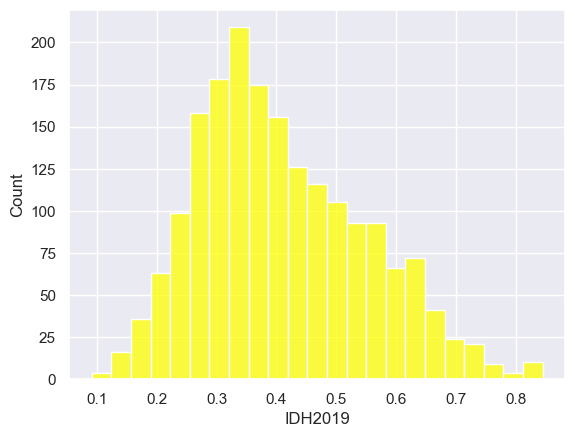

In [104]:
seaborn.histplot(datadismap.IDH2019, color='yellow')

In [105]:
ht.bins

array([0.40940512, 0.53944062, 0.62656757, 0.68924791, 0.74999441,
       0.79944501, 0.82690534, 0.8375162 , 0.84382218, 0.84521661])

In [106]:
HT_bins=list(ht.bins)
HT_bins.insert(0,datadismap.IDH2019.min())

<Axes: xlabel='IDH2019', ylabel='Count'>

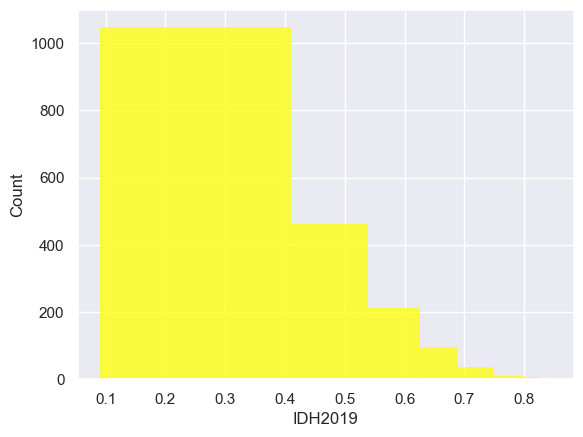

In [107]:
seaborn.histplot(datadismap.IDH2019, bins=HT_bins,color='yellow')

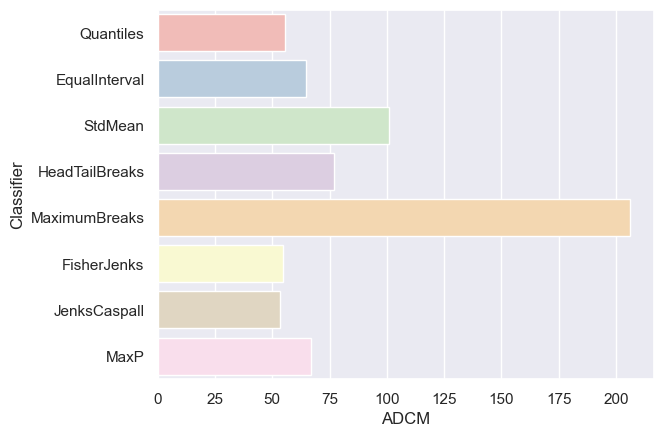

In [109]:
import seaborn
class5 = q5, ei5,msd, ht, mb5, fj5, jc5, mp5
# Collect ADCM for each classifier
fits = numpy.array([ c.adcm for c in class5])
# Convert ADCM scores to a DataFrame
adcms = pd.DataFrame(fits)
# Add classifier names
adcms['classifier'] = [c.name for c in class5]
# Add column names to the ADCM
adcms.columns = ['ADCM', 'Classifier']
ax = seaborn.barplot(
    y='Classifier', x='ADCM', data=adcms, palette='Pastel1'
)

In [110]:
datadismap['QU'] = q5.yb 
datadismap['FJ'] = fj5.yb
datadismap['JC'] = jc5.yb

In [111]:
class5new = q5,fj5, jc5
pd.DataFrame(
    {c.name: c.counts for c in class5new},
    index=['Class-{}'.format(i) for i in range(5)]
)

Quantiles  FisherJenks  JenksCaspall
Class-0        375          351           352
Class-1        375          584           484
Class-2        374          424           403
Class-3        375          330           351
Class-4        375          185           284

In [112]:
datadismap.IDH2019.describe()

count    1874.000000
mean        0.409405
std         0.140059
min         0.091195
25%         0.304729
50%         0.386020
75%         0.507002
max         0.845217
Name: IDH2019, dtype: float64

In [113]:
ei5Bins=list(ei5.bins)
ei5Bins.insert(0, datadismap.IDH2019.min())
ei5Bins

[0.09119489113467516,
 0.2419992358728173,
 0.39280358061095944,
 0.5436079253491015,
 0.6944122700872437,
 0.8452166148253858]

<Axes: xlabel='IDH2019', ylabel='Count'>

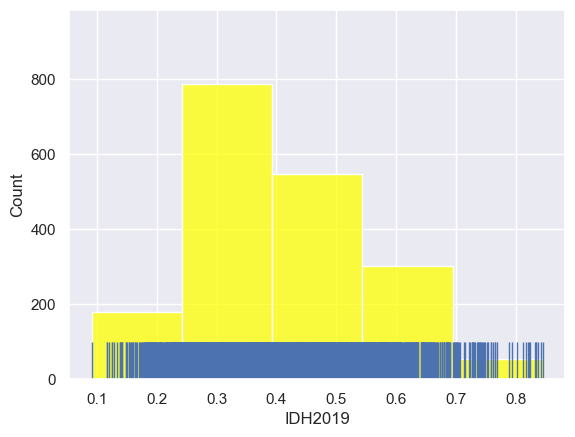

In [114]:
ax = seaborn.histplot(datadismap.IDH2019, bins=ei5Bins,color='yellow')
# Add rug on horizontal axis
seaborn.rugplot(
    data=datadismap,x='IDH2019', height=0.1,  ax=ax
)

In [115]:
datadismap.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1874 entries, 0 to 1873
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   DEPARTAMEN                1874 non-null   object  
 1   PROVINCIA                 1874 non-null   object  
 2   DISTRITO                  1874 non-null   object  
 3   geometry                  1874 non-null   geometry
 4   provDist                  1874 non-null   object  
 5   Ubigeo                    1874 non-null   object  
 6   Poblacion                 1874 non-null   int64   
 7   Superficie                1874 non-null   float64 
 8   IDH2019                   1874 non-null   float64 
 9   Educ_sec_comp2019_pct     1874 non-null   float64 
 10  NBI2017_pct               1874 non-null   float64 
 11  Viv_sin_serv_hig2017_pct  1874 non-null   float64 
 12  QU                        1874 non-null   int64   
 13  FJ                        1874 non-null 

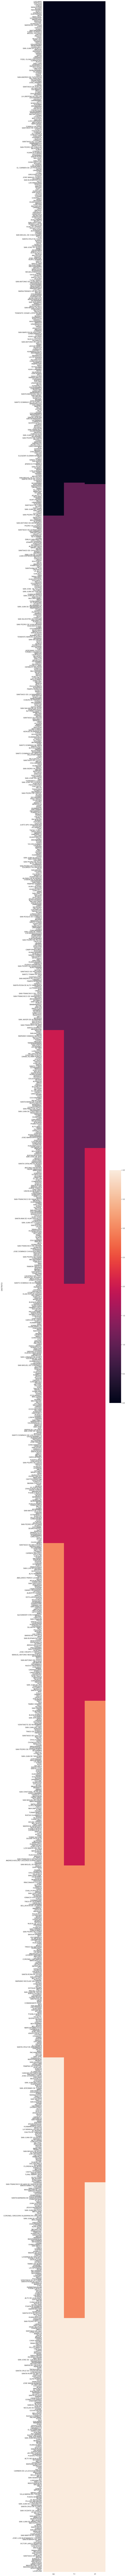

In [75]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, figsize=(9,300))
seaborn.set(font_scale=1)

ax = seaborn.heatmap(datadismap.sort_values('IDH2019').set_index('DISTRITO').loc[:,['QU','FJ','JC']],
                     yticklabels=1,
                     ax=ax)

In [116]:
datadismap.columns

Index(['DEPARTAMEN', 'PROVINCIA', 'DISTRITO', 'geometry', 'provDist', 'Ubigeo',
       'Poblacion', 'Superficie', 'IDH2019', 'Educ_sec_comp2019_pct',
       'NBI2017_pct', 'Viv_sin_serv_hig2017_pct', 'QU', 'FJ', 'JC'],
      dtype='object')

In [117]:

cols1=['IDH2019', 'Educ_sec_comp2019_pct',
       'NBI2017_pct', 'Viv_sin_serv_hig2017_pct']
datadismap[cols1].describe()

IDH2019  Educ_sec_comp2019_pct  NBI2017_pct  \
count  1874.000000            1874.000000  1874.000000   
mean      0.409405              55.769523    38.593330   
std       0.140059              15.728123    18.297153   
min       0.091195              11.974433     1.100000   
25%       0.304729              44.466678    24.900000   
50%       0.386020              57.164771    35.300000   
75%       0.507002              68.202230    49.275000   
max       0.845217              91.744878    99.400000   

       Viv_sin_serv_hig2017_pct  
count               1874.000000  
mean                  17.068783  
std                   16.354910  
min                    0.000000  
25%                    4.925000  
50%                   12.050000  
75%                   24.100000  
max                   96.500000

<Axes: >

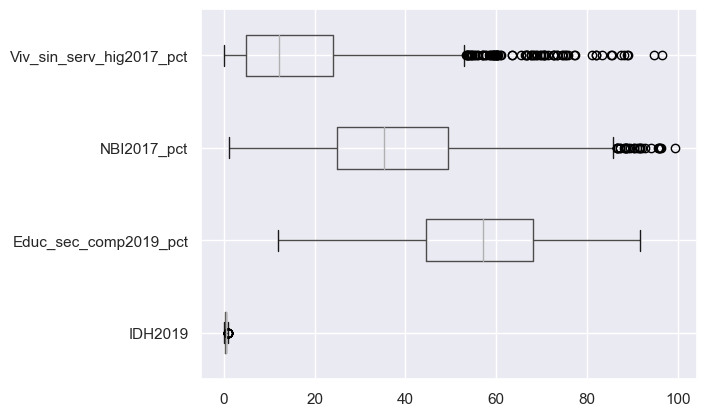

In [118]:
datadismap[cols1].boxplot(vert=False)

In [121]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 100))
datadismap['IDH2019']=scaler.fit_transform(datadismap['IDH2019'].values.reshape(-1,1))

<Axes: >

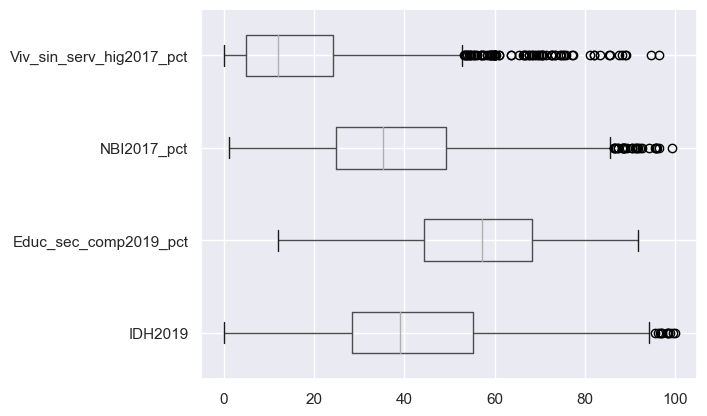

In [122]:
datadismap[cols1].boxplot(vert=False)

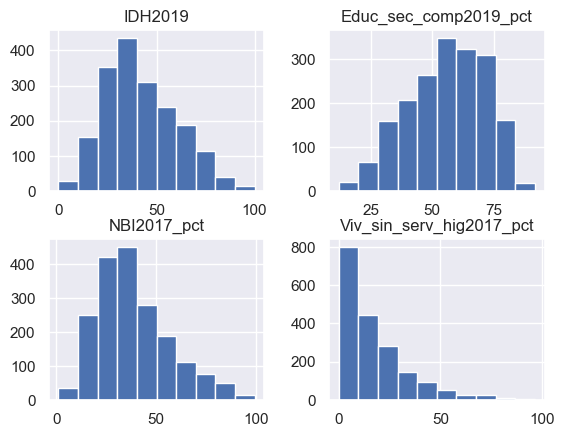

In [124]:
datadismap[cols1].hist();

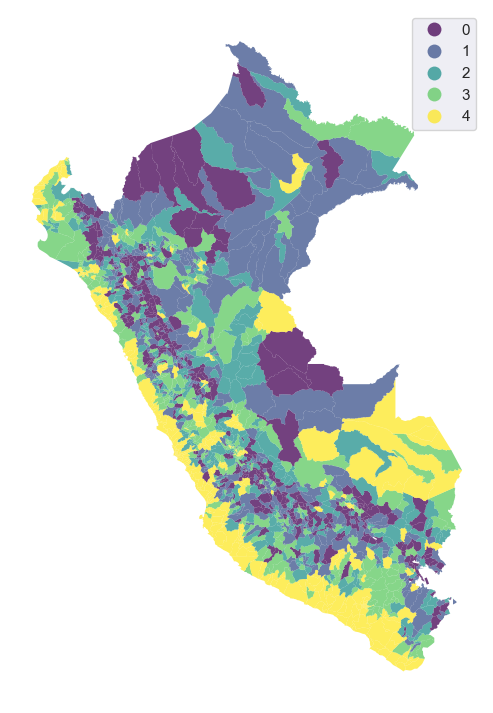

In [127]:
f, ax = plt.subplots(1, figsize=(9, 9))
datadismap.plot(column='QU', 
        cmap='viridis', 
        edgecolor='white', 
        linewidth=0., 
        alpha=0.75, 
                categorical=True,
        legend=True,
        #legend_kwds=dict(loc=2),
        ax=ax
       )

ax.set_axis_off()

In [ ]:
f, ax = plt.subplots(1, figsize=(9, 9))
datadismap.plot(column='NBI_2017_c', 
        cmap='viridis', 
        scheme='equal_interval',
        k=5, 
        edgecolor='white', 
        linewidth=0., 
        alpha=0.75, 
        legend=True,
        legend_kwds=dict(loc=2),
        ax=ax
       )

ax.set_axis_off()